# Explanatory Sentiment Analysis of Restaurant Reviews

This project explores a consumer **ratings and reviews** that reflect their dining experience in  **restaurants in London**. Reviews from [OpenTable](https://www.opentable.com/london-restaurants) were selected and analysed by content analysis. Results show  that the overall customer satisfaction on the dining experience in London restaurants was **positive**. Interestingly, the expensive restaurants  indicated a higher percentage of negative reviews than the less expensive restaurants did. Four dimensions used  in analysis to rate dining experience are **food, service,  atmosphere and value.**

In December 2022, a sample of the last 300 OpenTable reviews for each restaurant in London was chosen and grouped according to three price categories: `$`- priced: casual (3 restaurants), `$$`- priced: Formal dining, (3 restaurants), `$$$` - priced: most expensive or service for special occasions (3 restaurants).  All together, 2700 online reviews from 9 restaurants were analysed.

*Casual restaurants:*
- **Boxcar Bar & Grill**
- **Faros Restaurant**
- **The Havelock Tavern**

*Formal dining:*
- **Bar Douro City**
- **Hans' Bar & Grill**
- **UNI**

*Most expensive:*
- **14 Hills**
- **Nipa Thai**
- **Whitcomb's**

*Tools used in this project:*

- Python
- Numpy and Pandas for data cleaning
- NLTK library for sentiment analysis
- Matplotlib and Seaborn for data visualization

# Importing Libraries & Reading Data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from langdetect import detect
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading excel files
def import_file(name, col, col2):
    df = pd.read_excel(name, nrows=300) #last 300 reviews
    df['Restaurant'] = col #column with the restaurant's name because dataframes will be concatenated into one dataframe
    df['Price_Category'] = col2
    return df

Boxcar = import_file('Boxcar Bar & Grill.xlsx', 'Boxcar Bar & Grill', 'Casual')
Faros = import_file('Faros Restaurant.xlsx', 'Faros Restaurant', 'Casual')
Havelock = import_file('The Havelock Tavern.xlsx', 'The Havelock Tavern', 'Casual')
Douro = import_file('C:/Users/Marijana/Desktop/review/3 dolara/Bar Douro City.xlsx', 'Bar Douro City', 'Formal dining')
Hans = import_file("C:/Users/Marijana/Desktop/review/3 dolara/Hans' Bar & Grill.xlsx", "Hans' Bar & Grill", 'Formal dining')
Uni = import_file('C:/Users/Marijana/Desktop/review/3 dolara/UNI.xlsx', 'UNI', 'Formal dining')
Hills = import_file('C:/Users/Marijana/Desktop/review/4 dolara/14 Hills.xlsx', '14 Hills', 'Most expensive')
Nipa = import_file('C:/Users/Marijana/Desktop/review/4 dolara/Nipa Thai.xlsx', 'Nipa Thai', 'Most expensive')
Whitcombs = import_file("C:/Users/Marijana/Desktop/review/4 dolara/Whitcomb's.xlsx", "Whitcomb's", 'Most expensive')

In [3]:
# concatenating the dataframes
restaurants = pd.concat([Boxcar, Faros, Havelock, Douro, Hans, Uni, Hills, Nipa, Whitcombs], ignore_index=True)

# Transforming Data

Data was collected on **December 2, 2022**, and therefore all reviews written within a week do not show the correct date. For example, if the guest wrote a review on December 1, in the *Date* column it will be written that the guest **"Dined 1 day ago"**. With that said, we'll replace those values with the actual date the review was written.

Guests come from all over the world to dine in these restaurants and leave reviews, so the *Location* column has a lot of **different values**. Some guests wrote the *city* they come from, and some wrote the *country*, but all values will be adjusted to the **country** they come from, based on the city they wrote. Many guests are from cities in England, so those cities are stored in a *list* and will be renamed to England, while other values will be replaced through *dictionary*.

Also, a new column *Review_lower* is created that converts the *Review* column into reviews with **lower-case letters** for easier analysis of the content.

*Rating, Restaurant, Location and Price_Category* are converted to **category** because they only have a few unique values.

In [4]:
str_date = 'December 2, 2022'
date = pd.to_datetime(str_date)

#list of cities that will be replaces by the country USA
USA_location = ['New York Area', 'San Francisco', 'Los Angeles', 'New England', 'Chicago', 'Kent', 'Houston', 'Miami', 'Dallas',
'Atlanta', 'Hawaii', 'New Orleans', 'Norfolk', 'Orlando', 'Oklahoma City', 'Northern MI', 'Nashville', 'Tallahassee', 'Austin',
'Denver', 'Baltimore', 'Philadelphia', 'Richmond', 'Seattle', 'Austin', 'Detroit', 'Atlantic City', 'Phoenix', 'West Palm Beach',  
'Milwaukee', 'Tampa', 'Washington DC', 'Orange County', 'Portland', 'Las Vegas', 'Demoland (US)', 'Columbus', 'Fort Lauderdale',
'St. Louis', 'Memphis/West TN', 'Raleigh', 'Charleston', 'Boise', 'Minneapolis', 'San Diego', 'Louisville', 'Caribbean']

#list of cities in England
England_location = ['Oxford', 'Manchester', 'Bristol', 'Surrey', 'Hertfordshire', 'Yorkshire', 'Cambridge', 'Hampshire', 
'Birmingham', 'Nottingham', 'Gloucestershire', 'Essex', 'Berkshire', 'Cheshire', 'Buckinghamshire', 'Newcastle',
'East Sussex', 'West Sussex', 'Lancashire', 'Northampton', 'Warwickshire', 'Derbyshire', 'Bath', 'Dorset',
'Devon', 'Brighton', 'Leicestershire', 'Liverpool', 'County Durham']

#dictionary of remaining cities
countries = {'Edinburgh': 'Scotland', 'Glasgow': 'Scotland', 'Dublin': 'Ireland', 'Aberdeen': 'Scotland', 'Clacks': 'Scotland',
        'Angus': 'Scotland', 'Toronto': 'Canada', 'Vancouver': 'Canada', 'Montreal': 'Canada', 'Ottawa': 'Canada',
         'Edmonton': 'Canada', 'Munich': 'Germany', 'Berlin': 'Germany', 'Hamburg Area': 'Germany', 'Frankfurt': 'Germany',
        'Amsterdam': 'Netherlands', 'Naples': 'Italy', 'Milan': 'Italy', 'Cancun': 'Mexico', 'Puebla': 'Mexico',
         'Melbourne': 'Australia & New Zealand', 'Sydney': 'Australia & New Zealand', 'New Zealand': 'Australia & New Zealand',
         'Adelaide': 'Australia & New Zealand', 'South Wales': 'Wales', 'Istanbul': 'Turkey', 'Hong Kong Islan': 'Hong Kong'}


def transformData(restaurants):
    return (restaurants
.assign(Location = restaurants.Location.fillna('Other').replace(dict.fromkeys(USA_location, 'USA'))
         .replace(dict.fromkeys(England_location, 'England (excluding London)')).replace(['Unspecified', 'Exclusive'], 'Other')
         .replace(countries).astype('category'),
        Date = restaurants.Date.apply(lambda x: str(x).replace('Dined on', ''))
        .replace('Dined 1 day ago', str(date - dt.timedelta(days=1)))
        .replace('Dined 2 days ago', str(date - dt.timedelta(days=2))).replace('Dined 3 days ago', str(date - dt.timedelta(days=3)))
        .replace('Dined 4 days ago', str(date - dt.timedelta(days=4))).replace('Dined 5 days ago', str(date - dt.timedelta(days=5)))
        .replace('Dined 6 days ago', str(date - dt.timedelta(days=6))).replace('Dined 7 days ago', str(date - dt.timedelta(days=7))),
        Review_lower = restaurants.Review.str.lower()
        )
 .astype({'Rating': 'category', 'Restaurant': 'category', 'Price_Category': 'category', 'Date': 'datetime64[ns]'})

)

reviews = transformData(restaurants)
#reviews.info()
#reviews.memory_usage(deep=True).sum()

# Analysis of Dining Experience - Dimensions

Using *polarity_scores method* of **SentimentIntensityAnalyzer** we will extract **positive, negative and neutral** comments. Scores below 0 to -1 are considered *negative*, around 0 are *neutral*, and above 0 to 1 are *positive*. Polarity_scores method returns object which is a **sentiment dictionary**. We will make a dataframe from dictionary which will have 4 columns: *pos (positive), neu (neutral), neg (negative), compound (overall scores combined)*. Then we will merge it with *Review* dataframe.

Then, we'll set up specific **terms** related to **food, service, ambiance, and value** and define a function to pull them out from reviews and count them to see what guests write about the most in their reviews.
- Terms related to food: *food, dish, meal, portion, menu, offer, presented.*
- Terms related to service: *service, waiter, staff, manager, reception, welcome*
- Terms related to ambience: *decor, interior, design, music, atmosphere, ambience, view*
- Terms related to value: *price, pay, value, money, bill*

We will find the term *'view'* with *str.contains method* so that it doesn't include other words that have the word view in them (for example *'review'*). Then we will create a column *Ambience* to combine all terms in ambience dimension.

In [5]:
sia = SentimentIntensityAnalyzer()

scores = reviews.Review.apply(lambda x: sia.polarity_scores(x)) # sentiment dictionary

In [6]:
scoresdf = pd.DataFrame(scores.to_list())

reviews = reviews.merge(scoresdf, how='inner', left_index=True, right_index=True) # merging Review dataframe and scoresdf

In [7]:
#setting up terms in four dimensions (food, service, ambience, value)
food_terms = ['food', 'dish', 'meal', 'portion', 'menu', 'offer', 'presented']
service_terms = ['service', 'waiter', 'staff', 'manager', 'reception', 'welcome']
ambience_terms = ['decor', 'interior', 'design', 'music', 'atmosphere', 'ambience']
value_terms = ['price', 'pay', 'value', 'money', 'bill']

#defining function to extract the mentioned terms from the reviews
def terms(reviews, dimension_terms):
    terms = [t for t in dimension_terms if t in reviews]
    if terms:
        return terms
    else:
        return np.nan

#creating new columns with extacted terms for each dimension
#term view will be extracted with str.contains method
reviews = (reviews
 .assign(Food = reviews.Review_lower.apply(lambda x: terms(x, food_terms)).str.join(','),
         Service = reviews.Review_lower.apply(lambda x: terms(x, service_terms)).str.join(','),
         Ambience_temp = reviews.Review_lower.apply(lambda x: terms(x, ambience_terms)).str.join(','),
         Value = reviews.Review_lower.apply(lambda x: terms(x, value_terms)).str.join(','),
         View = np.where(reviews.Review_lower.str.contains(r'\bview', case=False), 'view', None)))

In [8]:
#creating column Ambience with all ambience terms including view
#dropping unnecessary columns
reviews = (reviews
 .assign(View = reviews.View.fillna(np.nan),
         Ambience = reviews.Ambience_temp.fillna('') + (',') + reviews.View.fillna(''))
 .drop(['Ambience_temp', 'View'], axis=1)
)

# Analysis of Dining Experience - Adjectives

In this part, we will analyze which **adjectives** are most often used by guests when describing their dining experience. Using *pos_tag from nltk library*, it will mark up a word in a text as corresponding to a particular **part of speech**. We are only interested in **adjectives and adverbs** *(JJ JJR, JJS, RB, RBR, RBS)*.

**Non-English reviews** were excluded to avoid possible misinterpretation of the non-English ones.

In [9]:
tokenizer = RegexpTokenizer(r'\w+')
tokens = reviews.Review.apply(lambda x: tokenizer.tokenize(x))
tags = tokens.apply(lambda x: nltk.pos_tag(x))

reviews = (reviews
 .assign(Ambience = reviews.Ambience.str.rstrip(',').str.lstrip(',').replace('', np.nan),
         Language_detect = reviews.Review.apply(detect), #detecting the language in which the review was written
         Adjectives = ([[word for word, pos in sentence if pos == 'JJ']
                        or [word for word, pos in sentence if pos == 'JJR']
                        or [word for word, pos in sentence if pos == 'JJS']
                        or [word for word, pos in sentence if pos == 'RB']
                        or [word for word, pos in sentence if pos == 'RBR']
                        or [word for word, pos in sentence if pos == 'RBS'] for sentence in tags]) #contains list of values
        )
 .query('Language_detect == "en"') # including only English reviews
 .drop(['Review_lower', 'Language_detect'], axis=1)

)

In [10]:
reviews.Adjectives = reviews.Adjectives.str.join(',') \
                                .replace('', np.nan) \
                                .str.lower() #getting rid of the list

In [11]:
#reviews.to_excel('Reviews.xlsx', index=False)

# Adjectives - polarity scores

In this part, we will apply the *polarity_scores method to Adjective* column in order to be able to detect positive, neutral and negative adjectives. This dataframe will be saved as **excel file** *'Polarity_scores.xlsx'* and it will be used in **further analysis** which is in another Jupyter Notebook called *'Dimensions - Adjectives'*

In [12]:
#creating dataframe of column Adjectives from Reviews dataframe
df_adjectives = pd.DataFrame(reviews.Adjectives \
    .str.split(',') \
    .explode() \
    .value_counts() \
    .index.to_series() \
    .reset_index(drop = True), columns=['Adjective'])

In [13]:
#applying polarity_scores
scores_dictionary = df_adjectives.Adjective.apply(lambda x: sia.polarity_scores(str(x))) #dictionary

In [14]:
#creating a dataframe from dictionary
scores_adjectives = pd.DataFrame(scores_dictionary.tolist())

In [15]:
#merging adjectives and matching polarity score
ps = df_adjectives.merge(scores_adjectives, right_index=True, left_index=True)
#ps.to_excel('Polarity_scores.xlsx', index=False)

# Data Visualization

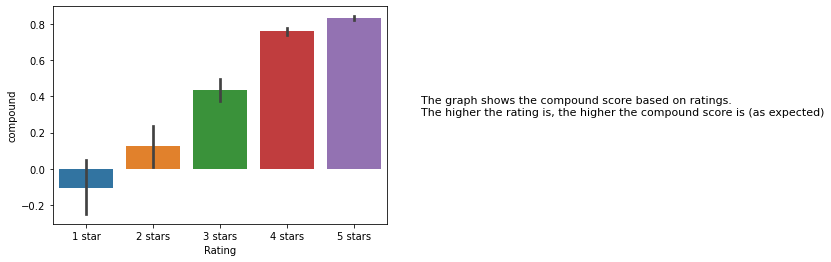

In [16]:
ax = sns.barplot(data=reviews, x='Rating', y='compound');
textstr = 'The graph shows the compound score based on ratings.\nThe higher the rating is, the higher the compound score is (as expected)'
plt.text(1.1,0.5, textstr, fontsize=11, transform=ax.transAxes);

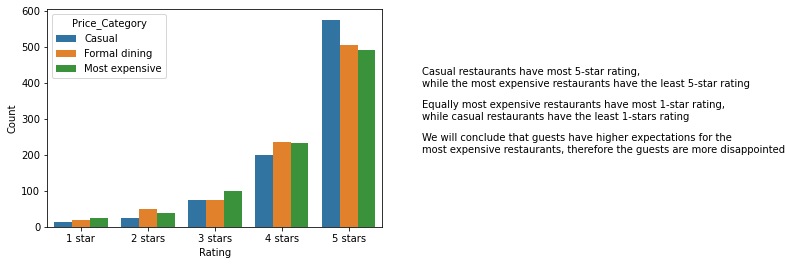

In [17]:
ratings_price = pd.DataFrame(reviews.groupby(['Price_Category', 'Rating'])['Rating'].count()) \
                .rename(columns={'Rating': 'Count'}).reset_index()

sns.barplot(data=ratings_price, x='Rating', y='Count', hue='Price_Category')
textstr1 = 'Casual restaurants have most 5-star rating,\nwhile the most expensive restaurants have the least 5-star rating\n'
textstr2 = 'Equally most expensive restaurants have most 1-star rating,\nwhile casual restaurants have the least 1-stars rating\n'
textstr3 = 'We will conclude that guests have higher expectations for the\nmost expensive restaurants, therefore the guests are more disappointed'
plt.text(1.1, 0.6, textstr1, transform=ax.transAxes)
plt.text(1.1, 0.45, textstr2, transform=ax.transAxes)
plt.text(1.1, 0.35, textstr3, transform=ax.transAxes);

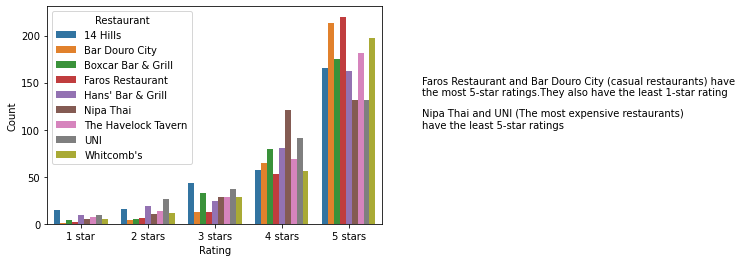

In [18]:
ratings_restaurant = pd.DataFrame(reviews.groupby(['Restaurant', 'Rating'])['Rating'].count()) \
                    .rename(columns={'Rating': 'Count'}).reset_index()

sns.barplot(data=ratings_restaurant, x='Rating', y='Count', hue='Restaurant');
textstr1 = 'Faros Restaurant and Bar Douro City (casual restaurants) have\nthe most 5-star ratings.They also have the least 1-star rating'
textstr2 = 'Nipa Thai and UNI (The most expensive restaurants)\nhave the least 5-star ratings'

plt.text(1.1, 0.6, textstr1, transform=ax.transAxes)
plt.text(1.1, 0.45, textstr2, transform=ax.transAxes);

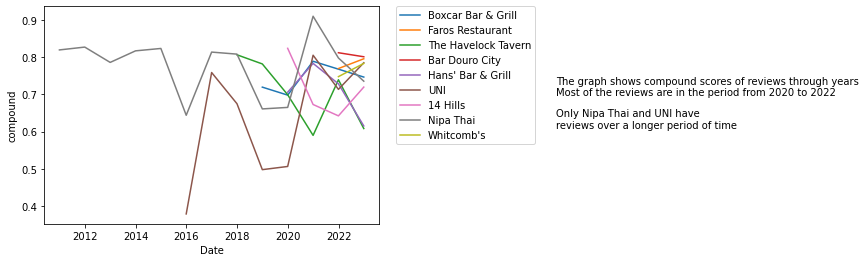

In [19]:
compound_restaurant = pd.DataFrame(reviews.groupby([pd.Grouper(key='Date', freq='Y'), 
                                                    pd.Grouper('Restaurant')])['compound'].mean()).reset_index()

sns.lineplot(data=compound_restaurant, x='Date', y='compound', hue='Restaurant')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0);
textstr1 = 'The graph shows compound scores of reviews through years.\nMost of the reviews are in the period from 2020 to 2022'
textstr2 = 'Only Nipa Thai and UNI have\nreviews over a longer period of time'
plt.text(1.5, 0.6, textstr1, transform=ax.transAxes)
plt.text(1.5, 0.45, textstr2, transform=ax.transAxes);

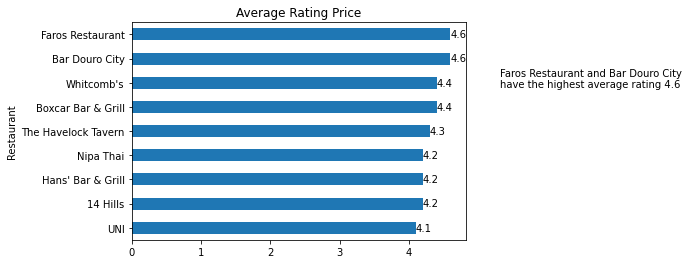

In [20]:
reviews['Star_Rating'] = reviews.Rating.str.rstrip('stars').astype('int')

ax = reviews.groupby('Restaurant')['Star_Rating'].mean().round(1).sort_values().plot(kind='barh')
ax.bar_label(ax.containers[0])
plt.title('Average Rating Price')
textstr = 'Faros Restaurant and Bar Douro City\nhave the highest average rating 4.6'
plt.text(1.1,0.7, textstr, transform=ax.transAxes);

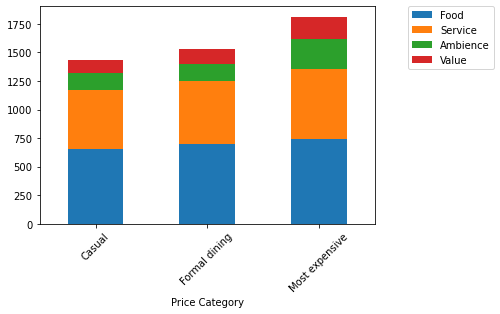

In [21]:
reviews.groupby('Price_Category')[['Food', 'Service', 'Ambience', 'Value']].count().plot(kind='bar', stacked=True);
plt.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0)
plt.xticks(rotation=45)
plt.xlabel('Price Category');